<a href="https://colab.research.google.com/github/kimisuke0503/colab-research/blob/main/needs_scan_panel/needs_RSCCMM_CF_cluster_membership.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

needs_scan_panel/needs_RSCCMM_CF_cluster_membership.ipynb

In [1]:
#ライブラリ
import pandas as pd
import numpy as np
import random
import sys
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import csv
from matplotlib.ticker import MaxNLocator

In [2]:
import pandas as pd
data_training = pd.read_csv('needs_scan_panel_training.csv', header=None)
data_test = pd.read_csv('needs_scan_panel_test.csv', header=None)
X_needs = data_training.values
test_needs = data_test.values
print(X_needs.shape)
print(test_needs)

(996, 18)
[[  1   1   0]
 [  2   4   0]
 [  2   8   0]
 ...
 [993   1   0]
 [993   2   1]
 [995   8   0]]


In [3]:
import numpy as np
import sys
import random

#関数化
def RSCCMM(X, C, delta):
  n, m = X.shape
  u = np.zeros((C,n))
  normalized_u = np.zeros((C,n))

  #要素の正規化
  #sys.float_info.epsilon を足してないと、類似度計算の時にlog(0)となってNaNが発生する
  # X = X + sys.float_info.epsilon
  # np.where(X == 0, sys.float_info.epsilon, X)
  normalized_X = X / np.sum(X, 1)[:, np.newaxis]

  #類似度
  s_it = np.array([np.sum(normalized_X * np.log(row + sys.float_info.epsilon), 1) for row in normalized_X])

  #二項関係
  #deltaの値が小さすぎると二項関係がなくなって、(※)式のところでゼロ徐算が発生する
  R = (s_it >= delta).astype(np.float64)

  #初期項目メンバシップ
  w = np.array([X[c] + sys.float_info.epsilon for c in random.sample(range(n), C)])
  w /= w.sum(1)[:,np.newaxis]

  #繰り返し処理
  for i in range(100):
    old_u = normalized_u.copy()
    u = np.zeros((C,n))
    normalized_u = np.zeros((C,n))

    #HCCMM的なクラスター割り当てによるメンバシップ
    s = np.log(w) @ X.T
    s_max = np.max(s, 0)
    u = (s >= s_max).astype(np.float64)

    #粒状性（二項関係）を考慮した上近似メンバシップ
    if(np.any(np.sum(R, 1) == 0)):
       raise Exception("二項関係がない")
    rough_u = ((u @ R.T) / np.sum(R, 1) > 0).astype(np.float64) #(※)
    normalized_u = rough_u / rough_u.sum(0)

    #正規化メンバシップ更新
    #ここでも微小値を足していないと次の類似度計算の時にNaNになって計算できなくなる
    w = (normalized_u @ X) + sys.float_info.epsilon
    if(np.any(np.isnan(w.sum(1)))):
      raise Exception("NaN発生")
    w /= w.sum(1)[:, np.newaxis]

    if np.abs(normalized_u - old_u).max() == 0:
      break

  return normalized_u.T @ w, rough_u, w

In [4]:
#roopの回数を指定し、最大のaucとその時のクラスター構造を返す関数(RSCCMM)
from sklearn.metrics import roc_auc_score

def RSCCMM_CF_AUC_CLUSTER(roop, test, X, C, delta):
  n, m = X.shape
  test_num, test_num_fact = test.shape
  auc_max = 0
  delta_max = 0
  every_cluster_objs_max = 0
  n_overlaps_max = 0
  rough_u_max = 0
  w_max = 0

  test_true = np.zeros(test_num)
  r_test_score = np.zeros(test_num)

  for i in range(test_num):
    test_true[i] = test[i][2]

  for i in range(roop):
    r, rough_u, w = RSCCMM(X, C, delta) # RSCCM法を適用

    for j in range(test_num):
      r_test_score[j] = r[test[j][0]][test[j][1]]

    auc = roc_auc_score(test_true, r_test_score) # AUCを計算

    if auc > auc_max:
      auc_max = auc
      rough_u_max = rough_u
      w_max = w


  return auc_max, rough_u_max, w_max

auc_max, rough_u_max, w_max = RSCCMM_CF_AUC_CLUSTER(10, test_needs, X_needs, 10, -6)
print("auc: ", auc_max)

auc:  0.8501436972556314


In [5]:
C = 100
name = f"needs_RSCCMM_user_hist_C_{C}"
loop = 10
delta_list = np.arange(-5, -9, -0.5)

auc_max:  0.8566432985580438
delta_max:  -8.5
number of users:  (996,)


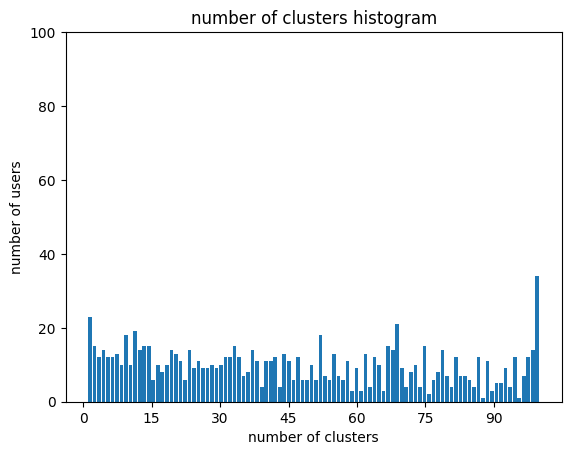

In [9]:
auc_max_max = 0
rough_u_max_max = 0
delta_max = 0

for delta in delta_list:
  auc_max, rough_u_max, w_max = RSCCMM_CF_AUC_CLUSTER(10, test_needs, X_needs, C, delta)
  if auc_max > auc_max_max:
    auc_max_max = auc_max
    rough_u_max_max = rough_u_max
    delta_max = delta

print("auc_max: ", auc_max_max)
print("delta_max: ", delta_max)

n_clusters_per_obj = np.sum(rough_u_max_max, axis=0) # 各対象が、いくつのクラスターに属しているか
print("number of users: ", n_clusters_per_obj.shape)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(n_clusters_per_obj, bins=C, rwidth=0.8)
ax.set_ylim(0, 100)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('number of clusters histogram')
ax.set_xlabel('number of clusters')
ax.set_ylabel('number of users')
fig.show()
plt.savefig(f"{name}.png", format="png", dpi=300)

output = [["AUC", "delta", "各対象の所属クラスター数"], [auc_max_max, delta_max, ', '.join(map(str, n_clusters_per_obj))]]
with open(f'{name}.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(output)

with open(f'{name}_rough_u.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(rough_u_max_max)

0.8533125124592996
-6.0
[11.0, 8.0, 2.0, 8.0, 9.0, 9.0, 20.0, 14.0, 18.0, 10.0, 20.0, 13.0, 18.0, 13.0, 9.0, 10.0, 11.0, 10.0, 20.0, 18.0, 17.0, 17.0, 20.0, 12.0, 18.0, 18.0, 17.0, 9.0, 5.0, 11.0, 4.0, 20.0, 1.0, 16.0, 9.0, 8.0, 20.0, 20.0, 8.0, 10.0, 3.0, 9.0, 2.0, 16.0, 11.0, 11.0, 1.0, 3.0, 5.0, 12.0, 9.0, 5.0, 18.0, 16.0, 1.0, 9.0, 6.0, 1.0, 4.0, 1.0, 13.0, 4.0, 16.0, 2.0, 8.0, 18.0, 6.0, 11.0, 4.0, 12.0, 20.0, 14.0, 20.0, 20.0, 9.0, 9.0, 20.0, 20.0, 2.0, 1.0, 7.0, 2.0, 10.0, 1.0, 3.0, 20.0, 19.0, 8.0, 12.0, 20.0, 19.0, 2.0, 6.0, 9.0, 8.0, 16.0, 3.0, 13.0, 20.0, 9.0, 12.0, 16.0, 17.0, 1.0, 5.0, 19.0, 4.0, 15.0, 17.0, 1.0, 2.0, 18.0, 10.0, 15.0, 19.0, 16.0, 17.0, 8.0, 2.0, 20.0, 12.0, 10.0, 19.0, 17.0, 3.0, 2.0, 18.0, 6.0, 2.0, 15.0, 4.0, 20.0, 4.0, 17.0, 1.0, 11.0, 1.0, 2.0, 4.0, 14.0, 10.0, 8.0, 4.0, 13.0, 6.0, 13.0, 2.0, 15.0, 7.0, 4.0, 12.0, 3.0, 9.0, 16.0, 18.0, 20.0, 7.0, 5.0, 20.0, 4.0, 1.0, 5.0, 14.0, 12.0, 3.0, 11.0, 8.0, 7.0, 20.0, 20.0, 1.0, 17.0, 8.0, 6.0, 12.0, 5.0, 12.

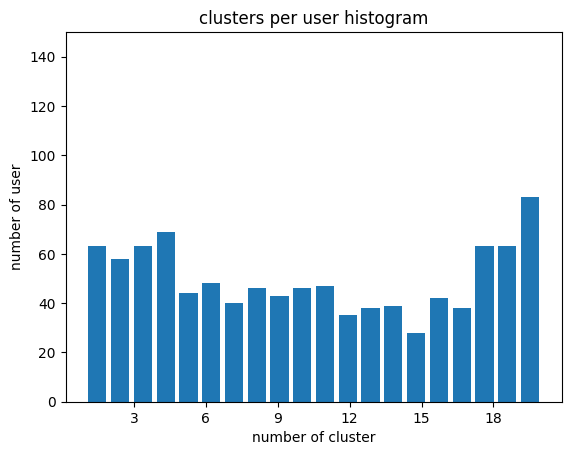

In [34]:
# 再現

input = pd.read_csv(f'{name}.csv', header=None)
input_auc = input.values[1, 0]
input_delta = input.values[1, 1]
input_n_clusters_per_user = list(map(float, input.values[1, 2].split(',')))

print(input_auc)
print(input_delta)
print(input_n_clusters_per_user)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(input_n_clusters_per_user, bins=C, rwidth=0.8)
ax.set_ylim(0, 150)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title('clusters per user histogram')
ax.set_xlabel('number of cluster')
ax.set_ylabel('number of user')
fig.show()
plt.savefig(f"{name}.png", format="png", dpi=300)

[ 39.  35.   2.  20.  34.  27.  82.  46.  68.  38.  77.  47.  57.  55.
  35.  29.  39.  41.  99.  74.  60.  56.  86.  48.  68.  96.  57.  28.
  11.  26.  10.  84.   3.  48.  27.  31.  87.  78.  27.  34.   3.  34.
  10.  47.  35.  25.   1.   6.  21.  48.  34.  18.  68.  49.   1.  34.
  17.   3.  10.   2.  40.  11.  47.   9.  26.  64.  19.  35.   6.  32.
  73.  51.  87.  95.  41.  25.  96.  77.   2.   3.  18.  10.  34.   5.
   9.  97.  77.  25.  46.  74.  73.   3.  21.  25.  35.  48.  19.  47.
  84.  33.  46.  46.  56.   1.  13.  76.   6.  88.  53.   1.   6.  64.
  27.  58.  73.  49.  65.  28.   4.  84.  46.  41.  76.  65.  14.   2.
  73.  12.   2.  55.   8.  69.  11.  55.   4.  46.   2.   4.   9.  46.
  42.  17.  11.  42.  12.  48.   2.  33.  17.  17.  47.   7.  25.  58.
  56.  99.  31.   6.  70.   8.   4.  18.  42.  32.   2.  39.  38.  27.
  92. 100.   1.  61.  19.  13.  30.  24.  40.  54.   4.  56.  47.   2.
  54.  28.   1.  19.  81.  49.   1.  60.  12.  60.   8.  55.  77.  39.
  66. 

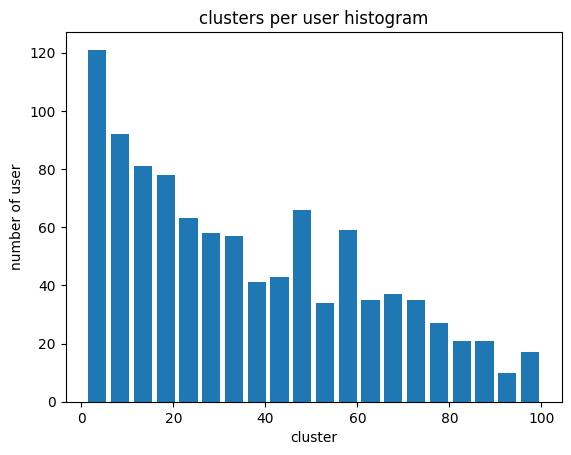

In [5]:
n_clusters_per_obj = np.sum(rough_u_max, axis=0) # 各対象が、いくつのクラスターに属しているか

print(n_clusters_per_obj)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.hist(n_clusters_per_obj, bins=20, rwidth=0.8)
ax.set_title('clusters per user histogram')
ax.set_xlabel('cluster')
ax.set_ylabel('number of user')
fig.show()

- 80から100このクラスターに属しているユーザーが70人くらいいる
- 一番多くいるのは1から10個のクラスターに属しているユーザー

→多くのクラスターに属している対象がモデルユーザー、あまりクラスターに属していないユーザーをノイズと考えるなら、クラスターを増やすごとにノイズが省かれて行って、ノイズ除去機構のように働いたと考えるのが妥当？

ただ、例えば、一つのクラスターにだけ属しているユーザーがいたとして、そのクラスターは何人のユーザーを持っているのか、というようなことも確認しないといけない。（11/14）


[['AUC', '各クラスターの要素数', 'オーバーラップしている要素の数', 'オーバーラップしていない要素の数'], [0.8473652734400956, '156.0, 512.0, 237.0, 541.0, 429.0, 529.0, 364.0, 691.0, 542.0, 417.0, 281.0, 402.0, 367.0, 526.0, 568.0, 240.0, 442.0, 760.0, 434.0, 566.0, 462.0, 64.0, 43.0, 187.0, 473.0, 239.0, 506.0, 450.0, 387.0, 64.0, 241.0, 556.0, 43.0, 657.0, 64.0, 308.0, 269.0, 454.0, 288.0, 568.0, 313.0, 773.0, 198.0, 326.0, 684.0, 367.0, 66.0, 43.0, 181.0, 167.0, 613.0, 572.0, 43.0, 43.0, 360.0, 515.0, 43.0, 146.0, 123.0, 646.0, 354.0, 43.0, 108.0, 413.0, 610.0, 293.0, 269.0, 443.0, 308.0, 110.0, 121.0, 516.0, 43.0, 511.0, 321.0, 43.0, 341.0, 324.0, 644.0, 332.0, 43.0, 350.0, 320.0, 202.0, 678.0, 435.0, 129.0, 512.0, 43.0, 43.0, 290.0, 594.0, 464.0, 43.0, 570.0, 75.0, 258.0, 292.0, 736.0, 167.0', 962.0, 34.0]]


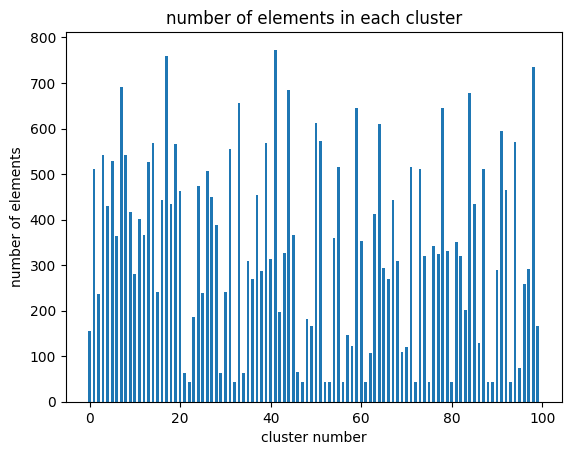

In [ ]:
# 可視化
name = "needs_RSCCMM_cluster"
C = 100
auc_max, every_cluster_objs_max, n_overlaps_max, w_max, output = RSCCMM_CF_AUC_CLUSTER(1, test_needs, X_needs, C, -7)

plt.bar(range(C), every_cluster_objs_max, width=0.6)

# plt.legend()
plt.title('number of elements in each cluster')
plt.xlabel('cluster number')
plt.ylabel('number of elements')
plt.savefig(f"{name}.png", format="png", dpi=300)

csv_output = [["AUC", "各クラスターの要素数", "オーバーラップしている要素の数", "オーバーラップしていない要素の数"]]
for row in output:
  csv_output.append(row)
print(csv_output)

with open(f'{name}.csv', 'wt', encoding='utf-8', newline='') as fout:
    writer = csv.writer(fout)
    writer.writerows(csv_output)

In [ ]:
対象別で所属しているクラスターの数